In [1]:
from functools import partial
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy.integrate as inte

n = 5
inverse_density = 2 / n
# make triangle grid
normal_x_row = jnp.linspace(-1, 1, n)
staggered_x_row = jnp.linspace(-1 + inverse_density / 2, 1 - inverse_density / 2, n - 1)
normal_y_column = jnp.linspace(-1, 1, n)

# now make the grid, taking alternating rows of the staggered grid and always the y column
vertices = []
for i, y in enumerate(normal_y_column):
    if i % 2 == 0:
        vertices.extend(
            jnp.column_stack((normal_x_row, jnp.ones_like(normal_x_row) * y))
        )
    else:
        vertices.extend(
            jnp.column_stack((staggered_x_row, jnp.ones_like(staggered_x_row) * y))
        )

vertices = jnp.array(vertices)

finished triangulation
made 38 new splits


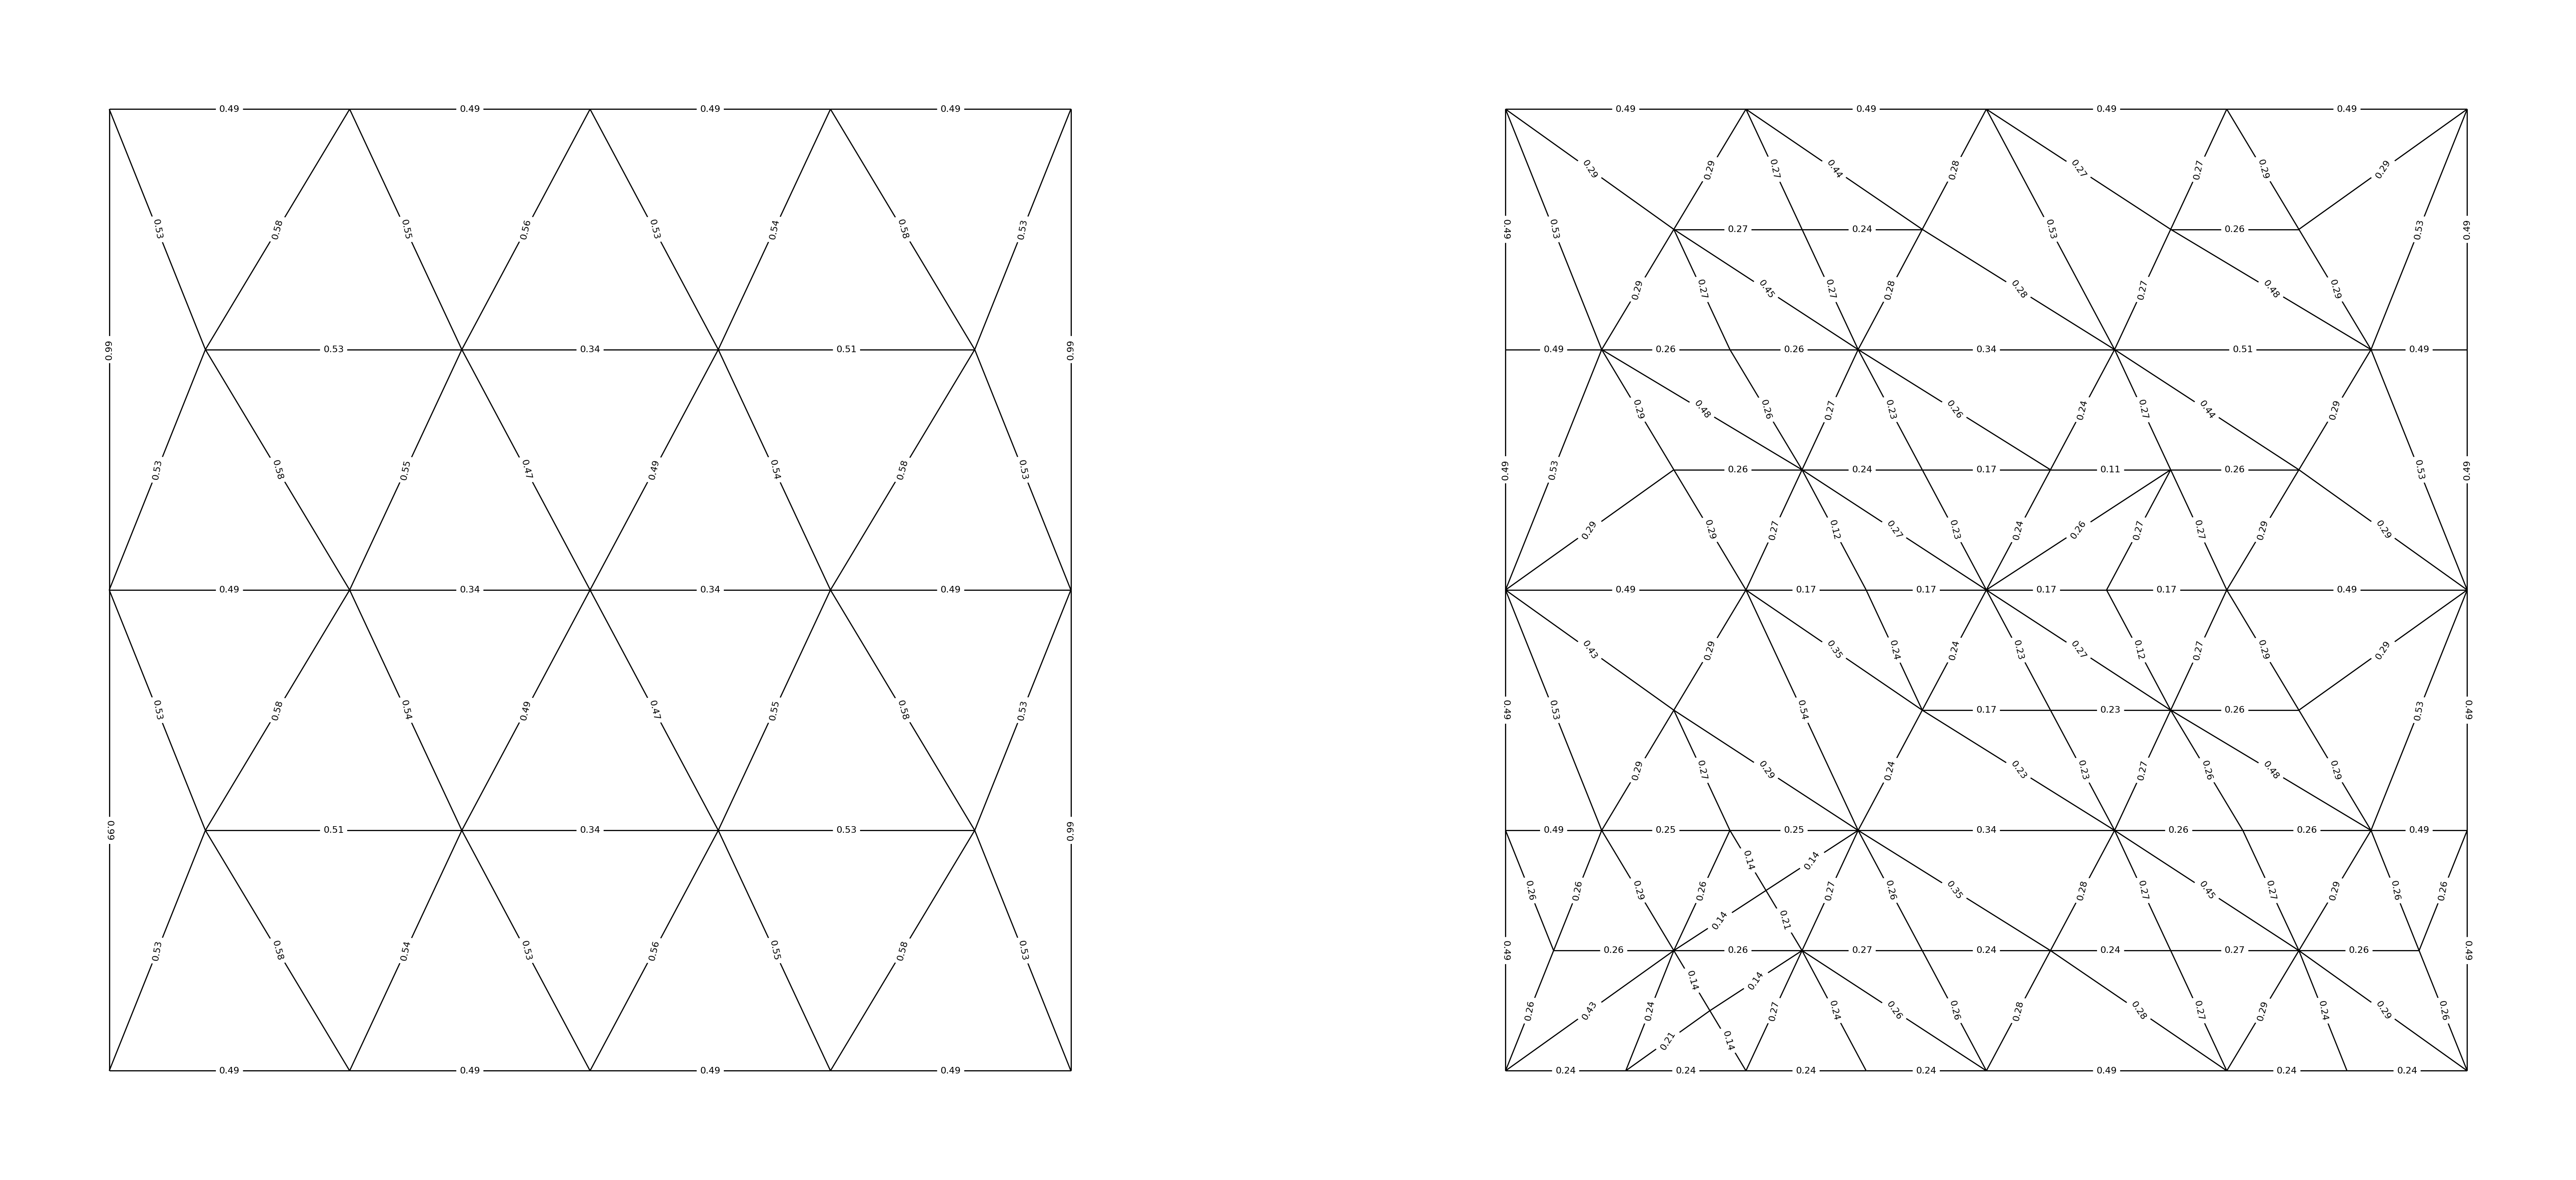

In [2]:
import networkx as nx

graph = nx.Graph()
import matplotlib.tri as tri

import scipy.spatial as sp

triang = sp.Delaunay(vertices)
print("finished triangulation")

# get all edges from the triangulation
edges = set()
for triangle in triang.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            edges.add((triangle[i], triangle[j]))

edges = list(edges)

from discrete_exterior_calculus import DEC, triangulate, metrics

metric = metrics.projected_bell_metric

mesh = DEC.Mesh(vertices=vertices, faces=triang.simplices, lazy=True)


distance_map = {}
for edge in edges:
    p1 = edge[0]
    p2 = edge[1]

    distance = metrics.measure_distance(vertices[p1], vertices[p2], metric)
    distance_map[triangulate.edge(p1, p2)] = distance
    graph.add_edge(p1, p2, weight=distance)

pos = {i: point for i, point in enumerate(vertices)}

# new_faces_and_lengths, new_vertices = triangulate.triangulate_mesh_with_edge_distances(
#     mesh, distance_map
# )
new_faces_and_lengths, new_vertices = triangulate.add_distances_to_mesh_with_metric(
    mesh, metric, max_subdivs=38
)
new_graph = nx.Graph()
added = set()
for (a, b, c), (A, B, C) in new_faces_and_lengths.items():
    for i, j, dist in [(a, b, C), (b, c, A), (c, a, B)]:
        if (i, j) in added:
            continue
        added.add((i, j))
        new_graph.add_edge(i, j, weight=dist)

new_pos = {i: point for i, point in enumerate(vertices)}

new_mesh = DEC.Mesh(
    vertices=new_vertices, faces=list(new_faces_and_lengths.keys()), lazy=True
)


def draw_graph_with_edge_weights(ax, graph, position):
    ax.set_aspect("equal")
    nx.draw(graph, pos=position, with_labels=False, node_size=0, ax=ax)
    edge_labels = {
        key: str(value)[:4]
        for key, value in nx.get_edge_attributes(graph, "weight").items()
    }
    nx.draw_networkx_edge_labels(
        graph, position, edge_labels=edge_labels, ax=ax, font_size=8
    )


fig, ax = plt.subplots(1, 2, figsize=(40, 40), dpi=200)

draw_graph_with_edge_weights(ax[0], graph, vertices)
draw_graph_with_edge_weights(ax[1], new_graph, new_vertices)

plt.show();

In [3]:
original_faces_and_lengths, vertices = triangulate.add_distances_to_mesh_with_metric(
    mesh, metric, max_subdivs=0
)

embedded_vertices = jnp.array([metrics.embed_to_bell(vertex) for vertex in vertices])
embedded_vertices = jnp.stack(
    (embedded_vertices[:, 0], embedded_vertices[:, 2], embedded_vertices[:, 1]), axis=0
).T

mesh = DEC.Mesh(
    vertices=embedded_vertices, faces=list(original_faces_and_lengths.keys()), lazy=True
)

mesh.dump_to_JSON(
    "bell_initial.json",
    {"Y": embedded_vertices[:, 1]},
    folder="../produced_solutions",
)

made 0 new splits
here .


In [4]:
embedded_vertices = jnp.array(
    [metrics.embed_to_bell(new_vertex) for new_vertex in new_vertices]
)
embedded_vertices = jnp.stack(
    (embedded_vertices[:, 0], embedded_vertices[:, 2], embedded_vertices[:, 1]), axis=0
).T


new_mesh = DEC.Mesh(
    vertices=embedded_vertices, faces=list(new_faces_and_lengths.keys()), lazy=True
)

new_mesh.dump_to_JSON(
    "bell_triangulated.json",
    {"Y": embedded_vertices[:, 1]},
    folder="../produced_solutions",
)

here .


In [5]:
import networkx as nx

graph = nx.Graph()
import matplotlib.tri as tri

import scipy.spatial as sp

triang = sp.Delaunay(vertices)
print("finished triangulation")

# get all edges from the triangulation
edges = set()
for triangle in triang.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            edges.add((triangle[i], triangle[j]))

edges = list(edges)

from discrete_exterior_calculus import DEC, triangulate

mesh = DEC.Mesh(vertices=vertices, faces=triang.simplices, lazy=True)


distance_map = {}
for edge in edges:
    p1 = edge[0]
    p2 = edge[1]

    distance = metrics.measure_distance(vertices[p1], vertices[p2])
    distance_map[triangulate.edge(p1, p2)] = distance
    graph.add_edge(p1, p2, weight=distance)

pos = {i: point for i, point in enumerate(vertices)}

new_faces_and_lengths, new_vertices = triangulate.triangulate_mesh_with_edge_distances(
    mesh, distance_map
)
print("finished subvidision")

new_graph = nx.Graph()
added = set()
for (a, b, c), (A, B, C) in new_faces_and_lengths.items():
    for i, j, dist in [(a, b, C), (b, c, A), (c, a, B)]:
        if (i, j) in added:
            continue
        added.add((i, j))
        # ordered = triangulate.edge(a,b)
        new_graph.add_edge(i, j, weight=dist)

new_pos = {i: point for i, point in enumerate(vertices)}

new_mesh = DEC.Mesh(
    vertices=new_vertices, faces=list(new_faces_and_lengths.keys()), lazy=True
)


def draw_graph_with_edge_weights(ax, graph, position):
    ax.set_aspect("equal")
    nx.draw(graph, pos=position, with_labels=False, node_size=0, ax=ax)
    edge_labels = {
        key: str(value)[:4]
        for key, value in nx.get_edge_attributes(graph, "weight").items()
    }
    nx.draw_networkx_edge_labels(
        graph, position, edge_labels=edge_labels, ax=ax, font_size=8
    )


fig, ax = plt.subplots(1, 3, figsize=(40, 40), dpi=200)

draw_graph_with_edge_weights(ax[0], graph, vertices)
draw_graph_with_edge_weights(ax[1], new_graph, new_vertices)
draw_graph_with_edge_weights(ax[2], new_graph, new_vertices * [0.5, 1.0])


plt.show();

finished triangulation


TypeError: measure_distance() missing 1 required positional argument: 'metric'

In [ ]:
V, F = vertices, triang.simplices
import intrinsic_triang as iDT

# use this line to run on your own mesh of interest
# V, F = pp3d.read_mesh(
#     "/Users/theoruterwurtzen/Desktop/MSc Thesis/code/app/terrain8k.obj"
# )

# initialize the glue map and edge lengths arrays from the input data
G = iDT.build_gluing_map(F)
l = iDT.build_edge_lengths(V, F)

print("Initial mesh:")
iDT.print_info(F, G, l)

# make a copy (so we preserve the original mesh), and flip to Delaunay
F_delaunay = F.copy()
G_delaunay = G.copy()
l_delaunay = l.copy()
iDT.flip_to_delaunay(F_delaunay, G_delaunay, l_delaunay)

print("After Delaunay flips:")
iDT.print_info(F_delaunay, G_delaunay, l_delaunay)

In [ ]:
from discrete_exterior_calculus import dijkstra

fig, ax = plt.subplots(1, 2, figsize=(40, 40), dpi=100)


def show_wave_propagation(start_pos, graph, vertices, simplices, ax):
    ax.set_aspect("equal")
    distances = dijkstra.dijkstra(start_pos, graph, vertices)
    print("finished dijkstra")
    distances = jnp.sin(distances * jnp.pi * 8)

    ax.tripcolor(
        vertices[:, 0], vertices[:, 1], simplices, distances, shading="gouraud"
    )


show_wave_propagation(jnp.array([0.5, 0.5]), graph, vertices, triang.simplices, ax[0])
show_wave_propagation(
    jnp.array([0.5, 0.5]),
    new_graph,
    new_vertices,
    list(new_faces_and_lengths.keys()),
    ax[1],
)

In [ ]:
from discrete_exterior_calculus import hyperbolic_laplacian


packed_face_lengths = jnp.array(
    [[*faces] + [*lengths] for faces, lengths in new_faces_and_lengths.items()]
)

laplace_matrix = hyperbolic_laplacian.compute_neg_laplacian(
    new_mesh, packed_face_lengths
)
print(jnp.mean(jnp.nonzero(jnp.abs(laplace_matrix))[0]))

In [ ]:
print(len(new_vertices))

In [ ]:
1 / 0

from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

mesh_name = f"NEW_wave_less_space.json"

n = len(new_vertices)
q = 1


# Define the vector field
def vector_field(t, y, args):
    # Extract u and v from y
    u = y[:n]
    v = y[n:]
    # Compute derivatives
    du_dt = v
    # dv_dt = jnp.tanh(laplace_matrix @ u)
    dv_dt = laplace_matrix @ u
    # Combine derivatives
    return jnp.concatenate([du_dt, dv_dt])


bottom_left_point_idx = jnp.argmin(
    jnp.linalg.norm(new_vertices - jnp.array([-1, -1]), axis=1)
)

# Define the ODE term
term = ODETerm(vector_field)

# Solver settings
solver = Dopri5()  # Runge-Kutta method
saveat = SaveAt(ts=jnp.linspace(0, 10, 100))  # Save at 100 evenly spaced time points
stepsize_controller = PIDController(rtol=1e-2, atol=1e-2)

initial_cond = jnp.exp(
    -25 * (jnp.linalg.norm(new_vertices - jnp.array([-1, 0]), axis=1) ** 2)
)

# Initial conditions
u0 = jnp.zeros(n)  # Initial condition for u (e.g., zero displacement)
v0 = jnp.zeros(n)  # Initial condition for v (e.g., zero velocity)
v0 = laplace_matrix @ initial_cond
u0 = u0.at[bottom_left_point_idx].set(1.0)  # Example: Displace the middle point
y0 = jnp.concatenate([initial_cond, v0])  # Combine u0 and v0 into a single state vector

# Solve the system
sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=10,
    dt0=0.1,
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=20000,
)

# Extract solutions
diffrax_sol = sol.ys[:, :n]  # Displacement solutions over time

# Visualization (optional)
# import matplotlib.pyplot as plt


# Save the solution to a file
new_mesh.dump_to_JSON(
    mesh_name,
    {
        "initial_cond": initial_cond,
        "initial_velocity": v0,
        "wave": {
            "data": diffrax_sol,
            "start": 0,
            "end": 10,
        },
    },
    folder="../produced_solutions",
)
